In [845]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting
import stats
import pystan

reload(misc)
reload(plotting)

first_year = 1992

data_dir = '.'
data_file = os.path.join(data_dir, 'immigration_with_metadata_2017_03_13.csv')
data = misc.read_article_data(data_file, first_year, rename_frames=True)
print "Loaded data for %d articles" % len(data.index)

data['tone'] = data['Pro'] - data['Anti']

tone_annotations = misc.read_article_data(os.path.join(data_dir, 'immigration_tone_annotations.csv'), first_year)
print "Loaded tone annotations for %d articles" % len(tone_annotations.index)

tone_annotations['tone'] = tone_annotations['Pro'] - tone_annotations['Anti']

framing_annotations = misc.read_article_data(os.path.join(data_dir, 'immigration_framing_annotations.csv'), first_year)
framing_annotations = misc.compute_entropy(framing_annotations)
print "Loaded framing annotations for %d articles" % len(framing_annotations.index)

last_date = data['date'].max()
print "Last date = ", last_date
last_year = last_date.year + 1


Loaded data for 33868 articles
Loaded tone annotations for 3857 articles
Loaded framing annotations for 4323 articles
Last date =  2012-12-31 00:00:00


In [846]:
# extract periods from dates
reload(misc)
data = misc.convert_dates(data, first_year)
tone_annotations = misc.convert_dates(tone_annotations, first_year)
framing_annotations = misc.convert_dates(framing_annotations, first_year)

Grouped data into 84 periods


(-1, 1)

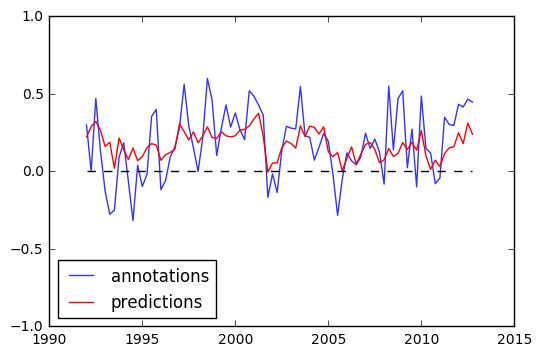

In [847]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'

reload(misc)
reload(plotting)

grouped = misc.group_article_data(data, group_by, first_year, group_tone=True, group_frames=True)
grouped_tone_annotations = misc.group_article_data(tone_annotations, group_by, first_year, group_tone=True)
grouped_framing_annotations = misc.group_article_data(framing_annotations, group_by, first_year, group_frames=True)

grouped = misc.compute_entropy(grouped)
grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

print "Grouped data into %d periods" % len(grouped.index)

fig, ax = plt.subplots()
#ax.fill_between(grouped_tone_annotations.f_date,  tone+tone_sd*2, tone-tone_sd*2, facecolor='grey', edgecolor='white', alpha=0.6)
ax.plot(grouped_tone_annotations.f_date, grouped_tone_annotations.tone, label='annotations', alpha=0.8)
ax.plot(grouped.f_date, grouped.tone, 'r', label='predictions')
ax.plot([grouped.f_date.min(), grouped.f_date.max()], [0, 0], 'k--')
ax.legend(loc='lower left')
ax.set_ylim(-1, 1)


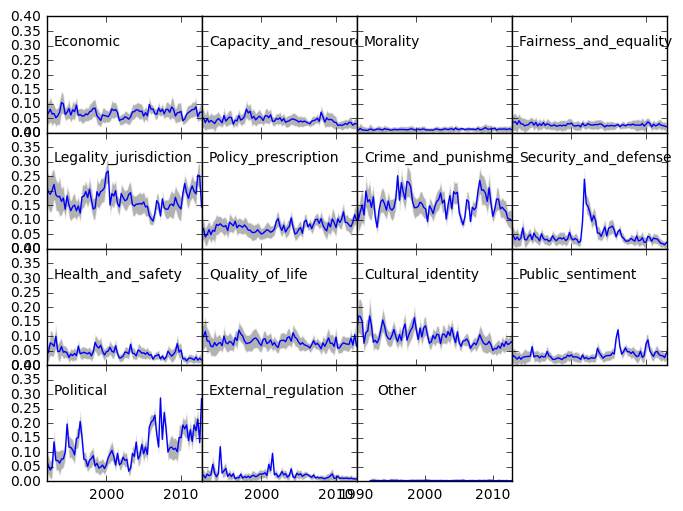

In [784]:
reload(plotting)
plotting.plot_frames(grouped, ymax=0.4)

### Load polls

1992
Loaded 69 polls
     Varname   House       Date  Topic  Subcode   L1    L2   L3   L4   C2  \
92   PSRAIMM    PSRA  5/28/1992    120      124  6.0  15.0  0.0  0.0  0.0   
14  IMMIGRAT  CBSNYT  6/21/1993    120      124  6.0  27.0  0.0  0.0  0.0   
39   IMMKEPT  GALLUP   7/9/1993    120      124  6.0  27.0  0.0  0.0  0.0   
93   PSRAIMM    PSRA  7/13/1994    120      124  5.0  12.0  0.0  0.0  0.0   
15  IMMIGRAT  CBSNYT   9/8/1994    120      124  6.0  27.0  0.0  0.0  0.0   

      ...     transformed   f_date  f_date_0  CNNIMM  IMMIGRAT IMMKEPT  \
92    ...       -1.286181  1992.25      0.25       0         0       0   
14    ...       -0.614208  1993.25      1.25       0         1       0   
39    ...       -0.676692  1993.50      1.50       0         0       1   
93    ...       -1.573627  1994.50      2.50       0         0       0   
15    ...       -0.646406  1994.50      2.50       0         1       0   

    IMMRATE  PSRAIMM  SPIMMIG  question  
92        0        1        0

(<matplotlib.figure.Figure at 0x1247d4f90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1247d4a90>)

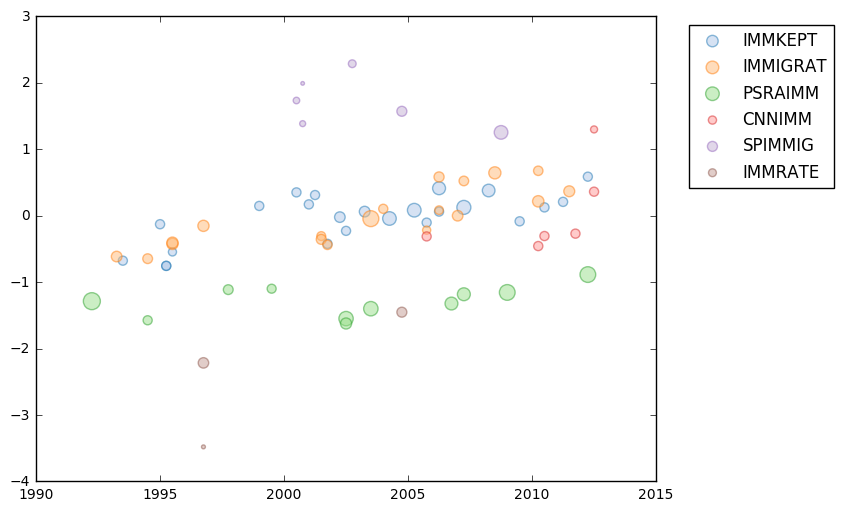

In [848]:
reload(misc)

filename = 'immigration_polls.csv'
print first_year
polls = misc.load_polls(filename, first_year, last_date)
polls = polls[polls['Varname'] != 'IMMLEGAL']
polls = misc.get_f_dates(polls, first_year, group_by)
print "Loaded %d polls" % len(polls.index)

# add in indicator variables for each question
varnames = polls['Varname'].values
questions = list(set(varnames))
questions.sort()
question_index = dict(zip(questions, range(len(questions))))    
for q_i, q in enumerate(questions):
    polls.ix[:, q] = 0
for q_i, q in enumerate(questions):
    polls.ix[polls['Varname']==q, 'question'] = q_i
    polls.ix[polls['Varname']==q, q] = 1
print polls.head() 

reload(plotting)
#plotting.plot_polling_data(polls)
plotting.plot_polling_data(polls, transform=True)

### Load data from wcalc

(0, 1)

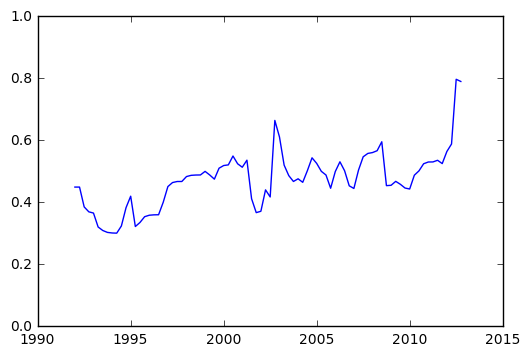

In [849]:
# Load data from wcalc
# specify the location of the mood data file
reload(misc)

group_by = 'quarter'
# read the mood data into a dataframe
if group_by == 'quarter':
    mood = pd.read_csv('wcalc_immigration_quarter.csv', header=0)
    mood['date'] = [pd.Timestamp(pd.datetime(int(mood.loc[i].year), (int(mood.loc[i].quarter))*3, 1)) for i in mood.index]
elif group_by == 'month':
    mood = pd.read_csv('wcalc_immigration_month.csv', header=0)
    mood['date'] = [pd.Timestamp(pd.datetime(int(mood.loc[i].year), int(mood.loc[i].month), 1)) for i in mood.index]
else:
    sys.exit()

mood = mood[mood['date'] >= pd.datetime(first_year, 1, 1)]
mood = mood[mood['date'] <= last_date]  

mood = misc.convert_dates(mood, first_year)
mood = misc.get_f_dates(mood, first_year, group_by)
mood.index = mood.p_quarter

# convert each quarter to a group (year/quarter)
if group_by == 'quarter':
    groups = mood.groupby('p_quarter')
elif group_by == 'month':
    groups = mood.groupby('p_month')
else:
    sys.exit()
    
# normalize and transform mood
mood['mood'] = mood['mood'] / 100.0
mood['transformed'] = np.log(mood.mood / (1 - mood.mood))

# store the vector of mood values from the previous quarter as a separate vector
mood['prev_mood'] = mood['mood'].shift().as_matrix()
mood['prev_transformed'] = mood['transformed'].shift().as_matrix()

# copy the mood data into the grouped dataframe (with the framing data)
grouped['mood'] = mood.mood
grouped['transformed'] = mood.transformed
grouped['prev_mood'] = mood.prev_mood
grouped['prev_transformed'] = mood.prev_transformed

plt.plot(mood.f_date, mood.mood)
plt.ylim(0, 1)



In [850]:
# create a "salient" variable that is 1 if the number of stories per quarter >= 350, otherwise 0
grouped['salient'] = grouped.apply(lambda row: int(row['stories'] >= 350), axis=1)

# add in interactions
grouped['toneXstories'] = grouped['tone'] * grouped['stories']
# between tone and the "salient" variable
grouped['toneXsalient'] = grouped['tone'] * grouped['salient']
# between tone and the "entropy" variable
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']

grouped['toneXstoriesXentropy'] = grouped['toneXstories'] * grouped['entropy']

grouped['toneXlogStories'] = grouped['tone'] * grouped['logStories']

## Approach 1: predict wcalc values from wcalc + other

### Compare some models through standard OLS

In [868]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'stories'])


Rmse: 0.0498663629611
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     70.14
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           3.26e-22
Time:                        22:40:37   Log-Likelihood:                 133.15
No. Observations:                  83   AIC:                            -258.3
Df Residuals:                      79   BIC:                            -248.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0250      0.0

In [750]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood',  'tone', 'stories', 'toneXstories'])


Rmse: 0.0501558708961
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     52.03
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           2.85e-21
Time:                        16:50:39   Log-Likelihood:                 133.19
No. Observations:                  83   AIC:                            -256.4
Df Residuals:                      78   BIC:                            -244.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.0346   

In [797]:
fitted, rmse = stats.ols(df=grouped, target='transformed', columns=['prev_transformed', 'f_date_0', 'tone', 'stories'])


Rmse: 0.200269100963
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     61.82
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           2.00e-23
Time:                        17:19:09   Log-Likelihood:                 18.278
No. Observations:                  83   AIC:                            -26.56
Df Residuals:                      78   BIC:                            -14.46
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

In [798]:
fitted, rmse = stats.ols(df=grouped, target='transformed', columns=['prev_transformed', 'f_date_0', 'tone', 'stories', 'toneXstories'])

Rmse: 0.201564667526
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     48.82
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           1.68e-22
Time:                        17:19:23   Log-Likelihood:                 18.279
No. Observations:                  83   AIC:                            -24.56
Df Residuals:                      77   BIC:                            -10.04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

### Compare some models using leave-one-out CV

In [852]:
columns = ['prev_transformed']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'tone', 'stories']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'tone', 'stories', 'toneXstories']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'toneXstories']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'tone', 'logStories']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'tone', 'logStories', 'toneXlogStories']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'toneXlogStories']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

#fig, ax = plotting.plot_polling_data(polls, transform=True)
#ax.plot(grouped.f_date, grouped.transformed, label='true')
#ax.plot(grouped.f_date, predictions, label='predictions')
#ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

Held-out RMSE: 0.220389293856
Held-out RMSE: 0.212560764468
Held-out RMSE: 0.207650530213
Held-out RMSE: 0.209629936195
Held-out RMSE: 0.207545560904
Held-out RMSE: 0.2063317204
Held-out RMSE: 0.208321936214
Held-out RMSE: 0.213243883811


In [851]:
columns = ['prev_transformed', 'f_date_0', 'tone', 'toneXlogStories', 'entropy', 'toneXentropy', 'logStories']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'tone', 'toneXlogStories', 'entropy', 'toneXentropy']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse

columns = ['prev_transformed', 'f_date_0', 'toneXlogStories', 'entropy', 'toneXentropy']
predictions, rmse = misc.eval_loocv(grouped, 'transformed', columns)
print "Held-out RMSE:", rmse



Held-out RMSE: 0.197939043728
Held-out RMSE: 0.196325883565
Held-out RMSE: 0.201765390368


In [853]:
columns = ['prev_mood', 'f_date_0', 'toneXlogStories']
predictions, rmse = misc.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse

columns = ['prev_mood', 'f_date_0', 'tone', 'toneXlogStories', 'entropy', 'toneXentropy', 'logStories']
predictions, rmse = misc.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse

columns = ['prev_mood', 'f_date_0', 'tone', 'toneXlogStories', 'entropy', 'toneXentropy']
predictions, rmse = misc.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse

columns = ['prev_mood', 'f_date_0', 'toneXlogStories', 'entropy', 'toneXentropy']
predictions, rmse = misc.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse



Held-out RMSE: 0.0496475397412
Held-out RMSE: 0.0460127545731
Held-out RMSE: 0.0456076647664
Held-out RMSE: 0.0467593715244


### Try running a Bayesian linear regression model

In [802]:
model = """
/*
*Simple normal regression example
*/

data {
  int N; //the number of observations
  int K; //the number of columns in the model matrix
  real y[N]; //the response
  matrix[N,K] X; //the model matrix
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred <- X*beta;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
  
  y ~ normal(linpred,sigma);
}
"""


In [814]:
columns = ['prev_transformed', 'tone', 'logStories', 'toneXlogStories']

X = grouped[columns].copy()
X = sm.add_constant(X).values[1:, :]
N, K = X.shape
y = grouped['transformed'].values[1:]

data = {'N': N, 'K': K, 'y': y, 'X': X}

# fit the model
fit = pystan.stan(model_code=model, data=data, iter=1000, chains=4)

betas = fit.extract('beta')['beta']
betas_means = np.mean(betas, axis=0)
betas_stds2 = np.std(betas, axis=0) * 2
for c_i, c in enumerate(['Intercept'] + columns):
    print "%20s \t  %0.4f  %0.4f  %0.4f" % (c, betas_means[c_i] - betas_stds2[c_i], betas_means[c_i], betas_means[c_i] + betas_stds2[c_i])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67a5fef2fa8062f0d36b04444770661b NOW.


           Intercept 	 0.2247  1.5076
    prev_transformed 	 0.3105  0.9713
                tone 	 0.2347  0.6182
          logStories 	 0.2477  0.9072
     toneXlogStories 	 0.2566  0.9066


## Approach 2: predicting poll results from wcalc

In [865]:
# grab tone and prev_mood data for each poll
tones = []
prev_moods = []
stories = []
entropies = []
for i in polls.index:
    if group_by == 'month':
        period = polls.loc[i]['p_month']
    elif group_by == 'quarter':
        period = polls.loc[i]['p_quarter']
    tones.append(grouped.loc[period]['tone'])
    prev_moods.append(mood.loc[period-1]['prev_mood'])
    stories.append(grouped.loc[period]['stories'])
    entropies.append(grouped.loc[period]['entropy'])
polls['tone'] = tones
polls['prev_mood'] = prev_moods
polls['prev_transformed'] = np.log(polls.prev_mood / (1 - polls.prev_mood))
polls['stories'] = stories
polls['logStories'] = np.log(stories) - np.mean(np.log(stories))
polls['entropy'] = entropies
polls['toneXstories'] = polls['tone'] * polls['stories']
polls['toneXlogStories'] = polls['tone'] * polls['logStories']
polls['entropyXtone'] = polls['tone'] * polls['entropy']

# TODO: base tone on previous X days, rather than current period


In [855]:
reload(stats)
poll_names = misc.get_top_poll_questions(polls)[1:]
columns = ['prev_transformed', 'tone', 'stories', 'entropy'] + poll_names
target = 'transformed'
fitted, rmse = stats.ols(df=polls, target=target, columns=columns, weight_column='N')
predictions, rmse_cv = stats.eval_loocv(polls, target, columns, weight_column='N')
print rmse_cv

Rmse: 0.294896061228
                            WLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.889
Model:                            WLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     51.60
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           2.04e-24
Time:                        17:58:17   Log-Likelihood:                -12.778
No. Observations:                  68   AIC:                             45.56
Df Residuals:                      58   BIC:                             67.75
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

In [857]:
reload(stats)
poll_names = misc.get_top_poll_questions(polls)[1:]
columns = ['prev_transformed', 'tone', 'logStories', 'entropy'] + poll_names
target = 'transformed'
fitted, rmse = stats.ols(df=polls, target=target, columns=columns, weight_column='N')
predictions, rmse_cv = stats.eval_loocv(polls, target, columns, weight_column='N')
print rmse_cv

Rmse: 0.291878602894
                            WLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.891
Model:                            WLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     52.81
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           1.14e-24
Time:                        17:58:56   Log-Likelihood:                -12.079
No. Observations:                  68   AIC:                             44.16
Df Residuals:                      58   BIC:                             66.35
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3


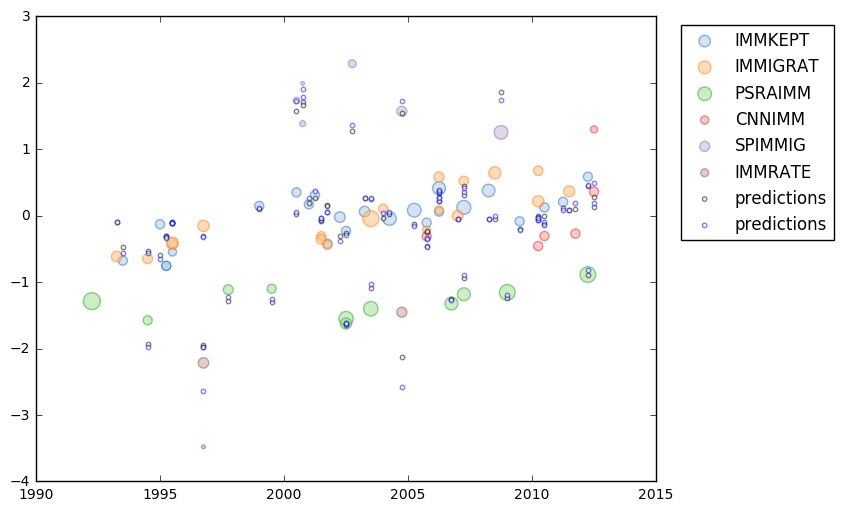

In [825]:
fig, ax = plotting.plot_polling_data(polls, transform=True)
ax.scatter(polls.f_date, predictions, s=10, facecolor='white', edgecolor='black', label='predictions', alpha=0.5)
ax.scatter(polls.f_date, predictions2, s=10, facecolor='white', edgecolor='blue', label='predictions', alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

### Try a hierarchical Bayesian model

In [858]:
model = """
/*
*Hierarchical model for polls
*/

data {
  int N; // the number of observations
  int K; // the number of columns in the model matrix
  int P; // number of poll indicators
  real y[N]; // the response
  matrix[N,K] X; // the model matrix
  matrix[N,P] polls_matrix;
}
parameters {
  vector[K] beta; // the regression parameters
  vector[P] poll_offsets; 
  real offset_mean;
  real<lower=0> offset_std;
  real<lower=0> sigma; // the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred = X * beta + polls_matrix * poll_offsets;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5); //prior for the slopes following Gelman 2008

  for(j in 1:P)
    poll_offsets[j] ~ normal(offset_mean, offset_std);

  offset_mean ~ normal(0, 1);
  offset_std ~ cauchy(0, 2.5);

  y ~ normal(linpred,sigma);
}
"""



In [866]:
target = 'transformed'
columns = ['prev_transformed', 'tone', 'stories', 'toneXstories', 'entropy', 'entropyXtone']
poll_names = misc.get_top_poll_questions(polls)

X = polls[columns].copy()
polls_indicators = polls[poll_names].values[1:, :]
X = sm.add_constant(X).values[1:, :]
N, K = X.shape
P = len(poll_names)
y = polls[target].values[1:]

data = {'N': N, 'K': K, 'P': P, 'y': y, 'X': X, 'polls_matrix': polls_indicators}

# fit the model
fit = pystan.stan(model_code=model, data=data, iter=1000, chains=4)

betas = fit.extract('beta')['beta']
betas_means = np.mean(betas, axis=0)
betas_stds2 = np.std(betas, axis=0) * 2
for c_i, c in enumerate(['Intercept'] + columns):
    print "%20s \t  %0.4f  %0.4f  %0.4f" % (c, betas_means[c_i] - betas_stds2[c_i], betas_means[c_i], betas_means[c_i] + betas_stds2[c_i])
    
offsets = fit.extract('poll_offsets')['poll_offsets']
offset_means = np.mean(offsets, axis=0)
offset_stds2 = np.std(offsets, axis=0) * 2
for c_i, c in enumerate(poll_names):
    print "%20s \t  %0.4f  %0.4f  %0.4f" % (c, offset_means[c_i] - offset_stds2[c_i], offset_means[c_i], offset_means[c_i] + offset_stds2[c_i])    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e510440cbefb6c7a37977e69248e032e NOW.


           Intercept 	  -1.1780  3.2411  7.6603
    prev_transformed 	  0.0740  0.3930  0.7120
                tone 	  -7.3217  2.3655  12.0526
             stories 	  -0.0013  0.0004  0.0020
        toneXstories 	  -0.0103  -0.0001  0.0101
             entropy 	  -3.2673  -1.7349  -0.2026
        entropyXtone 	  -4.2246  -0.3461  3.5324
             IMMKEPT 	  -1.9412  0.5158  2.9729
            IMMIGRAT 	  -1.9493  0.5046  2.9586
             PSRAIMM 	  -3.2527  -0.7925  1.6678
              CNNIMM 	  -2.0282  0.4214  2.8710
             SPIMMIG 	  -0.3162  2.1428  4.6018
             IMMRATE 	  -4.1237  -1.6329  0.8579


0.0708061612021


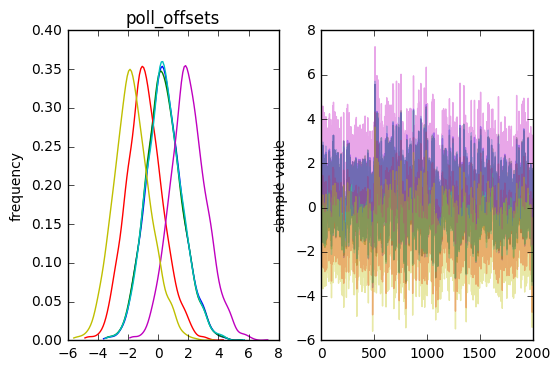

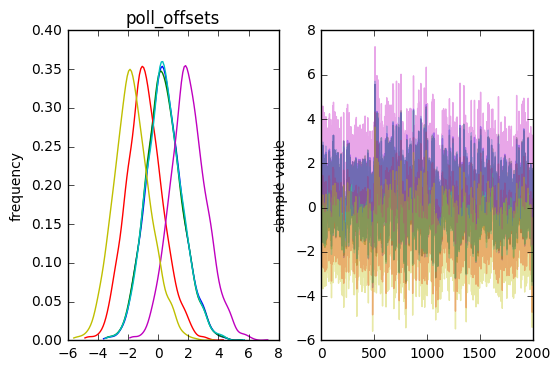

In [863]:
print np.mean(fit.extract('offset_mean')['offset_mean'])
fit.plot('poll_offsets')

In [860]:
reload(stats)
poll_names = misc.get_top_poll_questions(polls)[1:]
columns = ['prev_transformed', 'tone', 'logStories', 'toneXlogStories'] + poll_names
target = 'transformed'
fitted, rmse = stats.ols(df=polls, target=target, columns=columns)
print rmse_cv

Rmse: 0.372592881738
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     42.86
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           2.15e-22
Time:                        18:00:45   Log-Likelihood:                -23.945
No. Observations:                  68   AIC:                             67.89
Df Residuals:                      58   BIC:                             90.09
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

## Approach 3: Try estimating my own latent state of mood